# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_2m_1f_240216_2"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [50, 1870]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 18000
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,70.053519,835.262190,70.285445,833.021848,0.0,32.00000,743.000000,0.533333,32.00000,745.000000,-0.110247,7773.0,151.905756,73.670371,0.874528,4
1,1,0,1666.290536,960.906710,1668.161017,955.096531,0.0,1676.00000,855.000000,0.435294,1669.00000,891.000000,-0.584943,7407.0,131.938942,87.825284,0.746263,4
2,2,0,1675.779710,984.852174,1674.951769,985.907725,NaN,1675.77971,984.852174,NaN,1675.77971,984.852174,-0.931097,345.0,237.947725,85.984007,0.932428,4
3,3,0,1451.011496,977.052698,1450.553844,973.625198,0.0,1449.00000,908.000000,0.450980,1441.00000,1006.000000,-0.696023,11917.0,166.249413,103.287380,0.783589,4
4,0,3,70.108469,835.239301,70.359330,833.023418,0.0,32.00000,743.000000,0.533333,32.00000,745.000000,-0.111218,7781.0,151.775844,73.731503,0.874074,5
5,1,3,1665.872281,960.858668,1667.331502,954.985265,0.0,1676.00000,855.000000,0.435294,1667.00000,892.000000,-0.591800,7493.0,131.950613,88.707587,0.740298,5


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([0, 1, 3])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        -tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        -tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x  position_y  orientation
0   0     0         4    70.053519  835.262190    -0.110247
1   1     0         4  1666.290536  960.906710    -0.584943
2   2     0         4  1675.779710  984.852174    -0.931097
3   3     0         4  1451.011496  977.052698    -0.696023


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,70.053519,835.262190,70.285445,833.021848,0.0,32.000000,743.000000,0.533333,32.000000,745.000000,0.110247,7773.0,151.905756,73.670371,0.874528,4
1,1,0,1666.290536,960.906710,1668.161017,955.096531,0.0,1676.000000,855.000000,0.435294,1669.000000,891.000000,0.584943,7407.0,131.938942,87.825284,0.746263,4
3,2,0,1451.011496,977.052698,1450.553844,973.625198,0.0,1449.000000,908.000000,0.450980,1441.000000,1006.000000,0.696023,11917.0,166.249413,103.287380,0.783589,4
4,0,3,70.108469,835.239301,70.359330,833.023418,0.0,32.000000,743.000000,0.533333,32.000000,745.000000,-0.111218,7781.0,151.775844,73.731503,0.874074,5
5,1,3,1665.872281,960.858668,1667.331502,954.985265,0.0,1676.000000,855.000000,0.435294,1667.000000,892.000000,-0.591800,7493.0,131.950613,88.707587,0.740298,5
6,2,3,1451.016537,977.001343,1450.592902,973.561086,0.0,1474.000000,907.000000,0.450980,1486.000000,1007.000000,-0.696596,11913.0,166.362459,103.269397,0.784009,5
7,3,3,1645.318386,1008.515695,1645.184012,1008.536374,NaN,1645.318386,1008.515695,NaN,1645.318386,1008.515695,-1.495880,223.0,135.649162,80.771349,0.803398,5


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
25905,1,17994,886.026714,121.205112,902.716673,126.375891,0.0,798.000000,69.000000,0.658824,801.000000,79.000000,1.359287,17332.0,242.865686,95.026336,0.920275,3
25906,2,17994,310.436034,259.680935,322.448883,264.157511,NaN,310.436034,259.680935,NaN,310.436034,259.680935,1.283754,12405.0,206.145376,86.328688,0.908090,3
25907,0,17997,1299.541430,106.451527,1299.091509,109.140170,NaN,1299.541430,106.451527,NaN,1299.541430,106.451527,-1.319439,10934.0,155.648922,118.800669,0.646091,3
25908,1,17997,886.023144,121.206972,902.712883,126.371918,0.0,798.000000,69.000000,0.658824,804.000000,79.000000,1.359536,17326.0,242.843180,95.010873,0.920287,3
25909,2,17997,312.630153,259.131694,324.814484,263.851414,NaN,312.630153,259.131694,NaN,312.630153,259.131694,1.255368,12324.0,206.346226,85.843134,0.909358,3


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


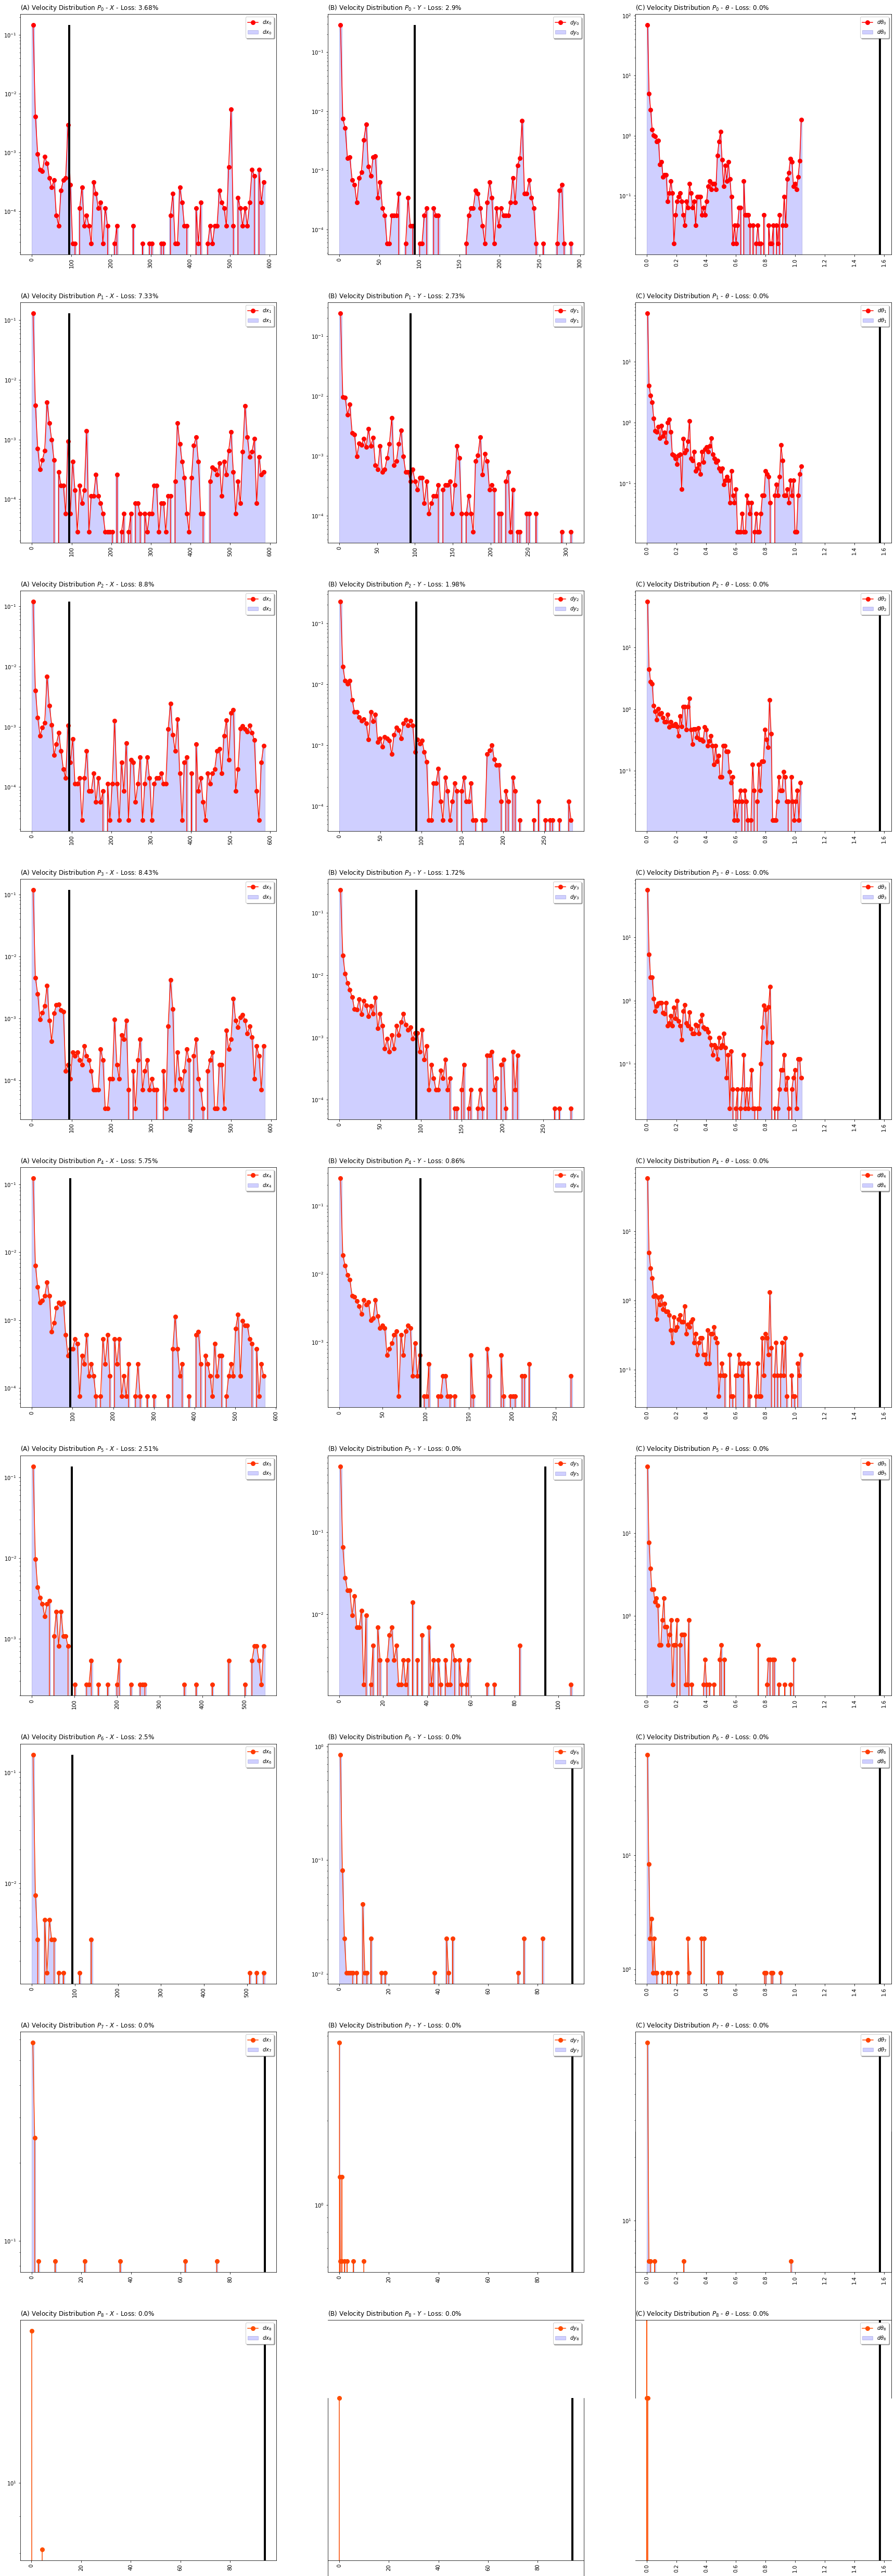

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,3,3660
1,4,9867
2,5,8185
3,6,3336
4,7,721
5,8,104
6,9,36


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 46.119734052955906 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,12.883554
1,3,False,True,False,0.536493
2,3,True,False,False,0.629125
3,3,True,True,False,0.077193
4,4,False,False,False,34.949245
5,4,False,True,False,0.872284
6,4,True,False,False,2.180709
7,4,True,True,False,0.081053
8,5,False,False,False,28.627118
9,5,False,True,False,0.467019


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 38.468586885894524 
	- Angle: 46.119734052955906 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0%
Final loss data X-axis: 0.7611111111111111%
Final loss data Y-axis: 0.2111111111111111%
Final loss data Angle : 0.5055555555555555%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.022222
1,3,False,False,True,0.172222
2,3,False,True,False,0.050000
3,3,False,True,True,0.516667
4,3,True,False,True,0.016667
5,3,True,True,False,0.433333
6,3,True,True,True,98.788889


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 38.468586885894524 
	- Angle: 46.119734052955906 



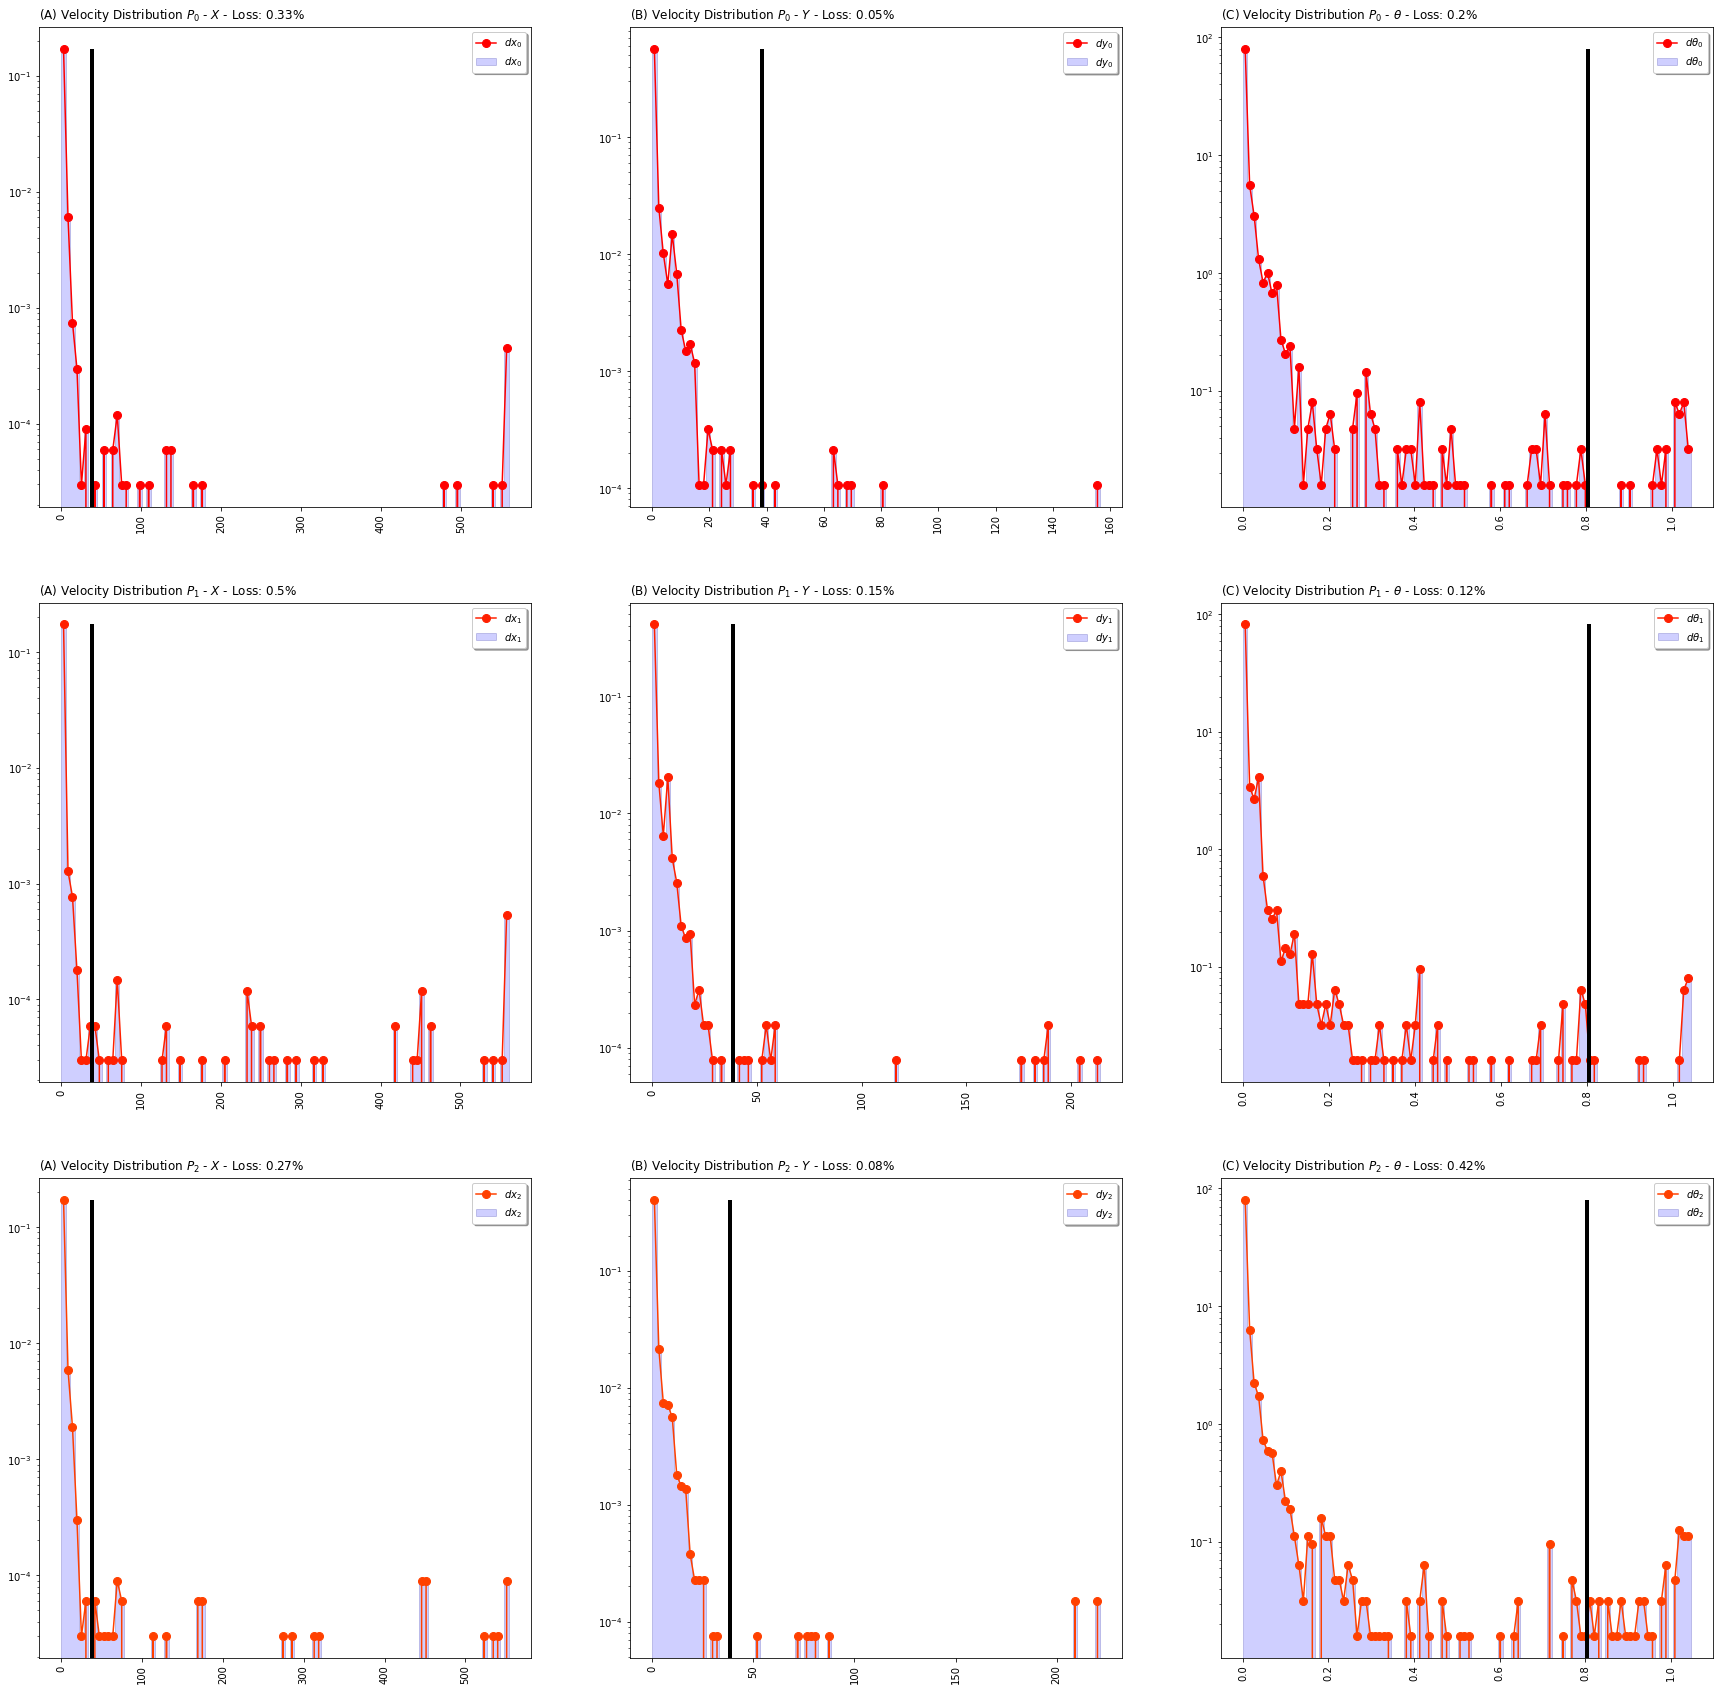

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,70.053519,835.262190,70.285445,833.021848,0.0,32.000000,743.000000,0.533333,32.000000,745.000000,0.110247,7773.0,151.905756,73.670371,0.874528,3,NaN,NaN,NaN,NaN,False,False,False
1221,1,0,1666.290536,960.906710,1668.161017,955.096531,0.0,1676.000000,855.000000,0.435294,1669.000000,891.000000,0.584943,7407.0,131.938942,87.825284,0.746263,3,NaN,NaN,NaN,NaN,False,False,False
2442,2,0,1451.011496,977.052698,1450.553844,973.625198,0.0,1449.000000,908.000000,0.450980,1441.000000,1006.000000,0.696023,11917.0,166.249413,103.287380,0.783589,3,NaN,NaN,NaN,NaN,False,False,False
3663,0,3,70.108469,835.239301,70.359330,833.023418,0.0,32.000000,743.000000,0.533333,32.000000,745.000000,-0.111218,7781.0,151.775844,73.731503,0.874074,3,3.0,0.018317,-0.007630,-0.073822,False,False,False
3664,1,3,1655.595333,984.687182,1656.257757,981.760819,0.0,1660.659193,931.757848,0.435294,1656.159193,950.257848,-0.591800,7493.0,131.950613,88.707587,0.740298,3,3.0,-3.565068,7.926824,-0.392248,False,False,False
3665,2,3,1451.016537,977.001343,1450.592902,973.561086,0.0,1474.000000,907.000000,0.450980,1486.000000,1007.000000,-0.696596,11913.0,166.362459,103.269397,0.784009,3,3.0,0.001680,-0.017118,-0.464206,False,False,False
3666,0,6,69.935702,835.555382,69.919846,833.556585,0.0,32.000000,743.000000,0.533333,32.000000,744.000000,-0.104673,7683.0,151.311614,73.029993,0.875815,3,3.0,-0.057589,0.105360,0.002182,False,False,False
3667,1,6,1655.497691,984.512961,1656.110172,981.651422,0.0,1660.920814,932.294118,0.419608,1658.420814,950.294118,-0.600375,7382.0,129.958172,88.941840,0.729118,3,3.0,-0.032548,-0.058074,-0.002858,False,False,False
3668,2,6,1451.135444,976.867159,1450.622038,973.543213,0.0,1449.000000,907.000000,0.533333,1452.000000,1033.000000,-0.701678,11909.0,166.585304,103.444395,0.783835,3,3.0,0.039636,-0.044728,-0.001694,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_2m_1f_240216_2_c.zip'